# Task 8
- Target column is "Response"

    Imports

In [1]:
import matplotlib.pyplot as plt
from pylab import figure
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

## Load dataset

In [2]:
def fix_csv(path: str
            ) -> None:
    with open(path, 'r') as file:
        data = file.read()

    with open(path, 'w') as file:
        file.write(data.replace('	', ','))
#fix_csv('marketing_campaign.csv')

dataset = pd.read_csv('marketing_campaign.csv')
dataset = dataset.drop(columns=['ID'])

dataset, X_test, y_train, y_test = train_test_split(
    dataset.drop(columns=['Response']),
    dataset['Response']
    )

dataset

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
1886,1957,PhD,Married,44155.0,1,1,19-01-2014,24,22,1,...,2,4,0,0,0,0,0,0,3,11
2206,1980,Graduation,Married,61014.0,0,1,11-08-2012,17,269,129,...,4,7,0,0,0,0,0,0,3,11
309,1992,Master,Together,42670.0,0,0,27-04-2013,12,154,2,...,4,4,0,0,0,0,0,0,3,11
1577,1947,PhD,Together,81574.0,0,0,28-04-2014,89,1252,0,...,8,1,0,1,1,0,0,0,3,11
893,1991,Basic,Single,26868.0,1,0,30-04-2014,52,0,0,...,2,7,0,0,0,0,0,0,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,1960,Graduation,Married,79530.0,0,0,17-05-2013,64,333,0,...,11,2,0,0,0,0,0,0,3,11
1905,1954,Graduation,Married,62820.0,0,0,11-05-2013,51,398,61,...,6,1,0,0,0,0,0,0,3,11
631,1958,PhD,Together,65488.0,0,0,13-06-2014,46,603,45,...,6,1,0,0,0,0,0,0,3,11
1923,1943,Master,Single,77598.0,0,0,01-10-2013,53,1193,33,...,13,3,0,0,1,0,0,0,3,11


## Analis

1. Get dataset split generator

In [3]:
def split(df: pd.DataFrame, 
          step: int=5
          ):
    for i in range(df.shape[1]//step+1):
        split_interval = ((step*i), (step*(i+1)))
        yield [df.iloc[:, split_interval[0]:split_interval[1]], split_interval]

dataset_split = split(dataset)

- Print splited dataset

In [4]:
split_data = next(dataset_split)
print(split_data[0], split_data[1], sep='\n')

      Year_Birth   Education Marital_Status   Income  Kidhome
1886        1957         PhD        Married  44155.0        1
2206        1980  Graduation        Married  61014.0        0
309         1992      Master       Together  42670.0        0
1577        1947         PhD       Together  81574.0        0
893         1991       Basic         Single  26868.0        1
...          ...         ...            ...      ...      ...
366         1960  Graduation        Married  79530.0        0
1905        1954  Graduation        Married  62820.0        0
631         1958         PhD       Together  65488.0        0
1923        1943      Master         Single  77598.0        0
1850        1995    2n Cycle         Single  83257.0        0

[1680 rows x 5 columns]
(0, 5)


2. Convert years to age

In [5]:
def convert_year(df: pd.DataFrame,
                 col: str
                 ) -> pd.DataFrame:
    df[col] = df[col].apply(func=lambda x: 2024-x)

    return df


3. Convert types to scalar

In [6]:
def type_to_scalar(df: pd.DataFrame,
                   col: str
                   ) -> pd.DataFrame:
    group = df[col].value_counts()

    replace_dict = {}
    for i, count in enumerate(group):
        replace_dict[group.index[i]] = i

    df[col] = df[col].map(replace_dict)

    return df

4. Convert nan to zero

In [7]:
def convert_nan(df: pd.DataFrame
                ) -> pd.DataFrame:
    for col in df.columns:
        df[col] = df[col].apply(lambda x: 0 if pd.isna(x) else x)
    return df

5. Use all convertors and mapping

In [8]:
def convert(df: pd.DataFrame
            ) -> pd.DataFrame:
    df = convert_nan(df)
    df = convert_year(df, 'Year_Birth')
    df = type_to_scalar(df, 'Education')
    df = type_to_scalar(df, 'Marital_Status')
    df = type_to_scalar(df, 'Dt_Customer')

    scaler = StandardScaler() #---
    new_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    return new_df

dataset = convert(dataset)
dataset

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
0,0.965781,0.077412,-0.999576,-0.289623,1.044548,0.897760,0.042911,-0.873598,-0.828630,-0.637353,...,-1.154572,-0.544984,-0.294407,-0.271076,-0.276104,-0.262111,-0.120386,-0.104069,0.0,0.0
1,-0.929100,-0.813352,-0.999576,0.341540,-0.822303,0.897760,1.491407,-1.114106,-0.102694,2.553417,...,-0.542492,0.697313,-0.294407,-0.271076,-0.276104,-0.262111,-0.120386,-0.104069,0.0,0.0
2,-1.917733,0.968175,-0.139285,-0.345218,-0.822303,-0.928193,-1.016074,-1.285897,-0.440681,-0.612425,...,-0.542492,-0.544984,-0.294407,-0.271076,-0.276104,-0.262111,-0.120386,-0.104069,0.0,0.0
3,1.789643,0.077412,-0.139285,1.111259,-0.822303,-0.928193,0.213322,1.359685,2.786356,-0.662281,...,0.681667,-1.787282,-0.294407,3.688997,3.621829,-0.262111,-0.120386,-0.104069,0.0,0.0
4,-1.835347,2.749701,0.721006,-0.936808,1.044548,-0.928193,1.266221,0.088431,-0.893289,-0.662281,...,-1.154572,0.697313,-0.294407,-0.271076,-0.276104,-0.262111,-0.120386,-0.104069,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,0.718623,-0.813352,-0.999576,1.034736,-0.822303,-0.928193,-1.052591,0.500730,0.085403,-0.662281,...,1.599787,-1.373183,-0.294407,-0.271076,-0.276104,-0.262111,-0.120386,-0.104069,0.0,0.0
1676,1.212940,-0.813352,-0.999576,0.409152,-0.822303,-0.928193,-1.265605,0.054073,0.276439,0.858321,...,0.069588,-1.787282,-0.294407,-0.271076,-0.276104,-0.262111,-0.120386,-0.104069,0.0,0.0
1677,0.883395,0.077412,-0.139285,0.509036,-0.822303,-0.928193,2.434756,-0.117718,0.878937,0.459474,...,0.069588,-1.787282,-0.294407,-0.271076,-0.276104,-0.262111,-0.120386,-0.104069,0.0,0.0
1678,2.119187,0.968175,0.721006,0.962407,-0.822303,-0.928193,0.067255,0.122790,2.612955,0.160340,...,2.211867,-0.959083,-0.294407,-0.271076,3.621829,-0.262111,-0.120386,-0.104069,0.0,0.0


In [9]:
#print((split_data[0]['Income']))
#dataset['Dt_Customer'] = pd.to_datetime(dataset['Dt_Customer'], format='%d-%m-%Y')
#dataset['Dt_Customer'].value_counts()

    Using Silhouette score, find the best number of clusters for GMM(implemented in sklearn.)


In [10]:
#kmeans = KMeans(n_clusters=5, random_state=420)
#labels = kmeans.fit_predict(dataset)

#silhouette_s = silhouette_score(dataset.values, labels)

def get_best_n_cluesters_gmm(df: pd.DataFrame
                         ) -> int:
    silhouette_scores = []

    for n_clusters in range(2, df.shape[1]):
        gmm = GaussianMixture(n_components=n_clusters)
        labels = gmm.fit_predict(df)
        
        silhouette_scores.append(
            silhouette_score(df, labels)
        )
    
    return silhouette_scores.index(max(silhouette_scores)) + 2

n_clusters_gmm = get_best_n_cluesters_gmm(dataset)

In [11]:
n_clusters_gmm

3

    Using Silhouette score, find the best number of clusters for KMeans(implemented in sklearn.)

In [12]:
#My version
def get_best_n_cluesters_kmeans(df: pd.DataFrame
                                ) -> int:
    silhouette_scores = []
    
    for n_clusters in range(2, df.shape[1]):
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(df)

        silhouette_scores.append(
            silhouette_score(df, labels)
        )
    
    return silhouette_scores.index(max(silhouette_scores)) + 2

n_clusters_kmeans = get_best_n_cluesters_kmeans(dataset)

In [13]:
n_clusters_kmeans

2

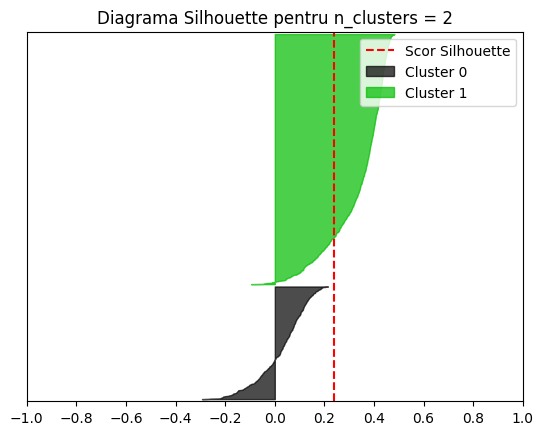

In [19]:
#book version KMeans
def draw_silhouette_plot(X, n_clusters):
    clusterer = GaussianMixture(n_components=n_clusters, random_state=69)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Calculează scorurile Silhouette pentru fiecare eșantion
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Scorul Silhouette variază de la -1 la 1
    plt.xlim([-1, 1])

    # (n_clusters + 1) * 10 este pentru inserarea unui spațiu gol între siluete
    # pentru fiecare cluster individual, pentru a le demarca clar.
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    plt.yticks([])  # Elimină etichetele de pe axa y
    plt.xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Linia verticală pentru scorul mediu Silhouette al tuturor valorilor
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        # Calculează noul y_lower pentru următorul plot
        y_lower = y_upper + 10  # 10 pentru eșantioanele cu valoarea 0

    plt.title(f'Diagrama Silhouette pentru n_clusters = {n_clusters}')
    plt.legend(['Scor Silhouette'] + [f'Cluster {i}' for i in range(n_clusters)])
    plt.show()

for i, k in enumerate(range(2, 3)):
    figure(i)
    draw_silhouette_plot(dataset, k)
    

In [20]:
gmm = GaussianMixture(n_components=3, random_state=69).fit(dataset)
scaler = StandardScaler()
scaler.fit(dataset)
centers = scaler.inverse_transform(gmm.means_)

pd.DataFrame(data=centers,
             index=[f'K{i}' for i in range(1, centers.shape[0]+1)],
             columns=dataset.columns)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
K1,0.175987,-0.122994,0.055018,0.500323,-0.600161,0.087101,0.004004,-0.002254,0.559866,0.619676,...,0.769760,-0.380136,-0.064921,0.113503,-0.276104,-0.262111,-0.120386,-0.003003,0.0,0.0
K2,-0.106908,0.113513,-0.004730,-0.564800,0.521427,0.051645,-0.011102,0.013109,-0.658021,-0.522417,...,-0.628779,0.414214,-0.012806,-0.271076,-0.276104,-0.262111,-0.120386,0.013814,0.0,0.0
K3,-0.023271,-0.162234,-0.139284,1.134038,-0.642251,-0.492562,0.039360,-0.053713,1.388642,0.589681,...,0.639723,-0.793024,0.248950,0.914937,2.078490,1.973156,0.906257,-0.054764,0.0,0.0


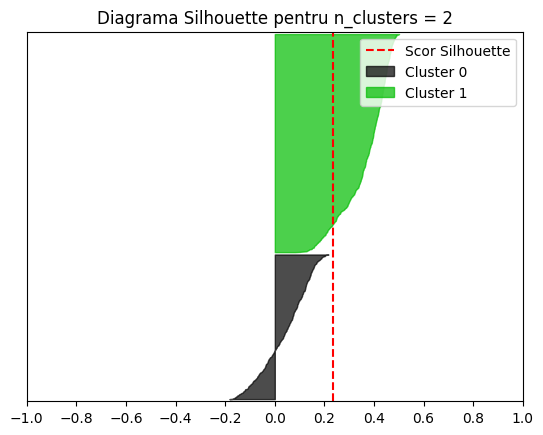

In [16]:
#book version KMeans
def draw_silhouette_plot(X, n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, random_state=69)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Calculează scorurile Silhouette pentru fiecare eșantion
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Scorul Silhouette variază de la -1 la 1
    plt.xlim([-1, 1])

    # (n_clusters + 1) * 10 este pentru inserarea unui spațiu gol între siluete
    # pentru fiecare cluster individual, pentru a le demarca clar.
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    plt.yticks([])  # Elimină etichetele de pe axa y
    plt.xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Linia verticală pentru scorul mediu Silhouette al tuturor valorilor
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        # Calculează noul y_lower pentru următorul plot
        y_lower = y_upper + 10  # 10 pentru eșantioanele cu valoarea 0

    plt.title(f'Diagrama Silhouette pentru n_clusters = {n_clusters}')
    plt.legend(['Scor Silhouette'] + [f'Cluster {i}' for i in range(n_clusters)])
    plt.show()

for i, k in enumerate(range(2, 3)):
    figure(i)
    draw_silhouette_plot(dataset, k)
    

In [17]:
kmeans = KMeans(n_clusters=2, random_state=69).fit(dataset)
scaler = StandardScaler()
scaler.fit(dataset)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

pd.DataFrame(data=centers,
             index=[f'K{i}' for i in range(1, centers.shape[0]+1)],
             columns=dataset.columns)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
K1,0.139707,-0.159239,0.022501,0.757206,-0.691345,-0.129679,0.012217,-0.005874,0.912161,0.746815,...,0.860267,-0.647582,0.025119,0.219500,0.416216,0.370781,0.156322,-0.002589,0.0,0.0
K2,-0.092677,0.105634,-0.014926,-0.502305,0.458615,0.086025,-0.008104,0.003897,-0.605097,-0.495412,...,-0.570672,0.429584,-0.016663,-0.145609,-0.276104,-0.245964,-0.103699,0.001717,0.0,0.0
